In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2022-06-17 22:39:49--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.111.153, 185.199.110.153, 185.199.109.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0s      

2022-06-17 22:39:49 (37.3 MB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh == http* ]]
+ PYBIND11_

In [ ]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
n = 20
mesh = UnitSquareMesh(n, n, 'crossed')

V = VectorElement('P', mesh.ufl_cell(), 2)
Q = FiniteElement('P', mesh.ufl_cell(), 1)

X = FunctionSpace(mesh, MixedElement([V, Q]))

Re = 100
f = Expression(('-2 * cos(x[0]) * sin(x[1]) * (cos(2*t) + 1/Re*sin(2*t))',
' 2 * sin(x[0]) * cos(x[1]) * (cos(2*t) + 1/Re*sin(2*t))'),degree=3, t=0, Re=Re)

u_ex = Expression((' - cos(x[0]) * sin(x[1]) * sin(2*t)',
' sin(x[0]) * cos(x[1]) * sin(2*t)'), degree=3, t=0)

p_ex = Expression('-0.25 * (cos(2*x[0]) + cos(2*x[1])) * pow(sin(2*t), 2)', degree=3, t=0)

T = 1.

# boundary conditions
def boundary(x, on_boundary):
    return on_boundary

bc_u = DirichletBC(X.sub(0), u_ex, boundary)

def origin(x, on_boundary):
    return near(x[0], 0) and near(x[1], 0)

bc_p = DirichletBC(X.sub(1), p_ex, origin, 'pointwise')

bc = [bc_u, bc_p]

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [ ]:
# Time stepping: explicit advection

# Inıtıal condition
u_ex.t = 0
u_pre = project(u_ex, VectorFunctionSpace(mesh, 'P', 2))

t = 0
niter = 10
dt = 0.05
T = dt*niter

u, p = TrialFunctions(X)
v, q = TestFunctions(X)

a = (1/dt * dot(u, v) *dx - p * div(v) * dx
     + 1/Re * inner(grad(u), grad(v))* dx + q * div(u) * dx)

for i in range(niter):
    t += dt
    # updating all the values with new t
    f.t = t
    u_ex.t = t
    p_ex.t = t

    L = (1/dt * dot(u_pre, v) * dx
         - dot(dot(grad(u_pre), u_pre), v) * dx
         + dot(f, v) *dx)


    x = Function(X)

    solve(a==L, x, bc)
    u, p = x.split()

    u_pre = u # u comes from the splitting

    h = 1/n
    u_max = norm(u.vector(),'linf')
    print('Courant number = ',dt* u_max/h)

    err_H1_u = errornorm(u_ex, u, 'H1')
    err_L2_p = errornorm(p_ex, p, 'L2')

    print('H1 norm, velocity = ', err_H1_u)
    print('L2 norm, pressure = ', err_L2_p)


Courant number =  0.08400692342254354
H1 norm, velocity =  0.0011281162018000118
L2 norm, pressure =  0.0033197393598327525
Courant number =  0.1671744774352459
H1 norm, velocity =  0.0036356205187157388
L2 norm, pressure =  0.009675945543936096
Courant number =  0.24867167932995055
H1 norm, velocity =  0.007225324747286222
L2 norm, pressure =  0.01568644057985931
Courant number =  0.3276842360047187
H1 norm, velocity =  0.011732127490924756
L2 norm, pressure =  0.02113316517581237
Courant number =  0.403422680111335
H1 norm, velocity =  0.01704545626361049
L2 norm, pressure =  0.025825548832379655
Courant number =  0.4751302581520869
H1 norm, velocity =  0.023086746972494663
L2 norm, pressure =  0.029604995735127045
Courant number =  0.5420904917105653
H1 norm, velocity =  0.02979631317406855
L2 norm, pressure =  0.03235186507681236
Courant number =  0.6036343362671642
H1 norm, velocity =  0.03712099491655062
L2 norm, pressure =  0.03399152222878241
Courant number =  0.659146866070764

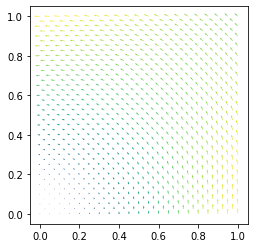

In [ ]:
plot(u)

In [ ]:
# Time stepping: explicit advection

# Inıtıal condition
u_ex.t = 0
u_pre = project(u_ex, VectorFunctionSpace(mesh, 'P', 2))

t = 0
niter = 10
dt = 0.05
T = dt*niter

u, p = TrialFunctions(X)
v, q = TestFunctions(X)

a = (1/dt * dot(u, v) *dx - p * div(v) * dx
     + 1/Re * inner(grad(u), grad(v))* dx + q * div(u) * dx) #remains the same

while t+dt< T:
    t += dt
    # updating all the values with new t
    f.t = t
    u_ex.t = t
    p_ex.t = t

    L = (1/dt * dot(u_pre, v) * dx
         + dot(f, v) *dx)

    u, p = TrialFunctions(X)

    a_adv= dot(dot(grad(u), u_pre), v) * dx


    x = Function(X)

    solve(a+a_adv==L, x, bc)
    u, p = x.split()

    u_pre = u # u comes from the splitting

    err_H1_u = errornorm(u_ex, u, 'H1')
    err_L2_p = errornorm(p_ex, p, 'L2')

    print('H1 norm, velocity = ', err_H1_u)
    print('L2 norm, pressure = ', err_L2_p)


  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
H1 norm, velocity =  0.001128116201800512
L2 norm, pressure =  0.0033197393598346876
H1 norm, velocity =  0.003637377202583347
L2 norm, pressure =  0.006753761410443488
H1 norm, velocity =  0.007238399663773684
L2 norm, pressure =  0.010017306316359794
H1 norm, velocity =  0.011777526654094959
L2 norm, pressure =  0.013006215951486653
H1 norm, velocity =  0.017155064347879438
L2 norm, pressure =  0.01563633789095772
H1 norm, velocity =  0.023297854175923328
L2 norm, pressure =  0.01784092474284821
H1 norm, velocity =  0.030142080925032715
L2 norm, pressure =  0.01957290073636788
H1 norm, velocity =  0.03761901244048223
L2 norm, pressure =  0.020807077258499843
H1 norm, velocity =  0.04564328909344991
L2 norm, pressure =  0.02154182064096382
H1 norm, velocity =  0.05410496640361449
L2 norm, pressure =  0.021800142357502314
